# Setting

In [1]:
import tensorflow as tf
import PIL.Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.densenet import preprocess_input, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import concatenate, Dense
import json
import glob
import numpy as np
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, f1_score, classification_report, balanced_accuracy_score
%matplotlib inline
df = pd.read_csv("./df_astrox.csv")

# df['class']: Label
# df['filename']: Filename for Chest radiographs (i.e. 'patient00001.jpg')

# Resize

In [2]:
def resize(img, size, padColor=0):
    interp = cv.INTER_AREA
    h, w = img.shape[:2]
    sh, sw = size
    if h > w:
        img2 = img[0:w, 0:w]
    else:
        img2 = img[0:h, 0:h]
    scaled_img = cv.resize(img2, size, interpolation=interp)
    return scaled_img

In [3]:
for img_path in tqdm(glob.glob('./images/*.jpg')):
    img = cv.imread(img_path)
    img = resize(img, (224,224), 0)
    file_name = './images/resize/' + img_path.split("/")[-1]
    cv.imwrite(file_name, img)

100%|██████████| 5361/5361 [00:09<00:00, 581.28it/s]


# Histogram equalization

In [4]:
for img_path in tqdm(glob.glob('./images/resize/*.jpg')):
    img = cv.imread(img_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    equ = cv.equalizeHist(img)
    file_name = './images/he/' + img_path.split("/")[-1]
    cv.imwrite(file_name, equ)

100%|██████████| 5361/5361 [00:08<00:00, 607.12it/s]


# Train / valid / test split

In [5]:
df['file_path'] = './images/he/' + df['file_name'] 

df_trainvalid, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_valid = train_test_split(df_trainvalid, test_size=0.2, random_state=42)

# TRAINING SET
train_ce = df_train[df_train['class'] == "ce"].file_path.tolist()
train_non_ce = df_train[df_train['class'] == "non_ce"].file_path.tolist()

# VALIDATION SET
val_files = df_valid.file_path.tolist()
val_label = df_valid['class'].apply(lambda x: 1 if x == "ce" else 0).to_numpy()

# TEST SET
test_files = df_test.file_path_he.tolist()
test_label = df_test['class'].apply(lambda x: 1 if x == "ce" else 0).to_numpy()

# Data augmentation

In [6]:
data_aug_gen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=[0.95, 1.05],
                                  fill_mode='constant', cval=0)
valset_gen = ImageDataGenerator(rescale=1./255)
testset_gen = ImageDataGenerator(rescale=1./255)

### Train: Augmentation CE x 6, Train Non-CE x 3 
### Valid, Test: no augmentation

In [7]:
train_ce_imgs = []
for img_path in train_ce:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in data_aug_gen.flow(x, batch_size=1, seed=42):
        train_ce_imgs.append(batch)
        i += 1
        if i == 6:
            break
train_ce_imgs = np.vstack(train_ce_imgs)


In [8]:
train_non_ce_imgs = []
for img_path in train_non_ce:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    i = 0
    for batch in data_aug_gen.flow(x, batch_size=1, seed=42):
        train_non_ce_imgs.append(batch)
        i += 1
        if i == 3:
            break
train_non_ce_imgs = np.vstack(train_non_ce_imgs)


In [9]:
val_imgs = []
for img_path in val_files:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in valset_gen.flow(x, batch_size=1, shuffle = False, seed=42):
        val_imgs.append(batch)
        break
val_imgs = np.vstack(val_imgs)

# 이건 순서대로 val_imgs 만 불러온 것 (no augmentation)

In [10]:
test_imgs = []
for img_path in test_files:
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    for batch in testset_gen.flow(x, batch_size=1, shuffle = False, seed=42):
        test_imgs.append(batch)
        break
test_imgs = np.vstack(test_imgs)
# 이건 순서대로 test_imgs 만 불러온 것 (no augmentation)

In [11]:
train_ce = [train_ce_imgs, np.repeat(1, train_ce_imgs.shape[0])]
train_non_ce = [train_non_ce_imgs, np.repeat(0, train_non_ce_imgs.shape[0])]
# label을 붙임 (1, 0)

In [12]:
train_img = np.concatenate((train_ce[0], train_non_ce[0]), axis=0)
train_label = np.concatenate((train_ce[1], train_non_ce[1]), axis=0)

# Modeling

In [15]:
# Hyperparameters
epochs = 1000
batch_size = 32
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
densenet = DenseNet121(
    weights='./brucechou1983_CheXNet_Keras_0.3.0_weights.h5',
    include_top=True,
    input_shape=(224, 224, 3),
    classes=14
)
out = layers.Dense(1, activation='sigmoid')(densenet.layers[-2].output)
model = tf.keras.Model(inputs=densenet.input, outputs=out)


trained_model_dir = './model_astrox/'
model_name = 'model_ex-{epoch:03d}_acc-{val_loss:03f}.h5'
model_path = os.path.join(trained_model_dir, model_name)


# Callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=model_path,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_weights_only=False,
                                                save_best_only=True,
                                                mode='auto',
                                                save_freq='epoch')
early_stopping = EarlyStopping(patience=50)


model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])


history_model = model.fit(train_img, train_label,
                          validation_data=(val_imgs, val_label),
                          epochs=epochs,
                          shuffle=True,
                          batch_size=batch_size,
                          steps_per_epoch=len(train_img)//batch_size,
                          callbacks=[checkpoint, early_stopping])


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

KeyboardInterrupt: 

# Test

In [16]:

tf.keras.backend.clear_session()

trained_model_dir = './model_astrox/'

model = tf.keras.models.load_model(os.path.join(
    trained_model_dir, os.listdir(trained_model_dir)[-1]))

print("Loaded")

Loaded


In [17]:
y_true = test_label
predictions = model.predict(test_imgs)
y_pred = (predictions > 0.5).astype(np.int)
y_proba = predictions

In [18]:
conf_mat = confusion_matrix(y_true, y_pred, labels=[1, 0])
TP = conf_mat[0][0]
TN = conf_mat[1][1]
FN = conf_mat[0][1]
FP = conf_mat[1][0]
print(conf_mat)
print("Acc", (TP+TN)/(TP+TN+FP+FN))
print("Sensitivity", TP/(TP+FN))
print("Specificity", TN/(TN+FP))
print("AUROC", roc_auc_score(y_true, y_proba))
print("Recall", recall_score(y_true, y_pred))
print("F1",  f1_score(y_true, y_pred))
print("Weighted accuracy", balanced_accuracy_score(y_true, y_pred))

print(classification_report(y_true, y_pred))

[[119 133]
 [ 47 517]]
Acc 0.7794117647058824
Sensitivity 0.4722222222222222
Specificity 0.9166666666666666
AUROC 0.7720224023415513
Recall 0.4722222222222222
F1 0.569377990430622
Weighted accuracy 0.6944444444444444
              precision    recall  f1-score   support

           0       0.80      0.92      0.85       564
           1       0.72      0.47      0.57       252

    accuracy                           0.78       816
   macro avg       0.76      0.69      0.71       816
weighted avg       0.77      0.78      0.76       816



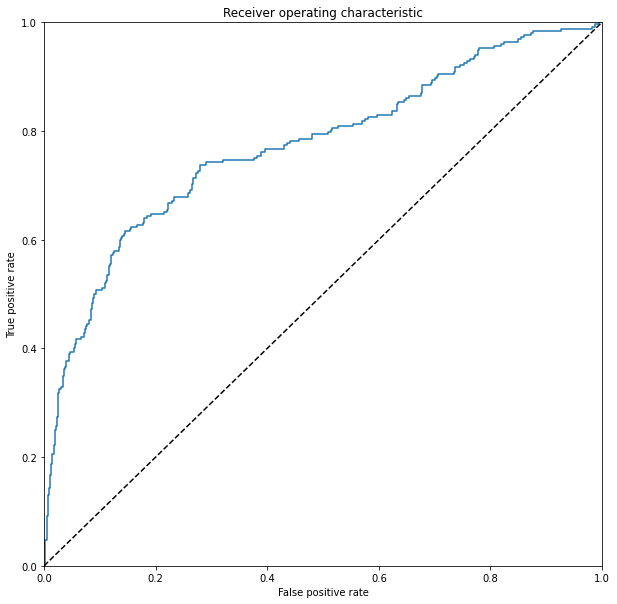

0.7720224023415513

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_true, y_proba)


def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver operating characteristic')
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.show()


plt.figure(figsize=(10,10))
plot_roc(fpr, tpr)
roc_auc_score(y_true, y_proba)

# Grad-cam

In [20]:
import cv2

def get_gradcam(model, IMAGE_PATH, LAYER_NAME):
    image_array = IMAGE_PATH
    img = image_array.astype(np.float32)

    # Create a graph that outputs target convolution and output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    # Get the score for target class
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        loss = predictions

    # Extract filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Build a ponderated map of filters according to gradients importance
    cam = np.ones(output.shape[0:2], dtype=np.float32)

    for index, w in enumerate(weights):
        cam += w * output[:, :, index]

    # Heatmap visualization
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)

    heatmap = ((cam - cam.min()) / (cam.max() - cam.min()))

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    alphanum = 0.6
    output_image = cv2.addWeighted(cv2.cvtColor(
        (image_array*255).astype('uint8'), cv2.COLOR_BGR2RGB), alphanum, cam, 1-alphanum, 0)
    output_image = cv2.cvtColor(
        output_image.astype('uint8'), cv2.COLOR_BGR2RGB)

    return output_image

In [22]:
def get_class(model, IMAGE_PATH):
    img = IMAGE_PATH
    img = np.expand_dims(img, axis=0)

    predictions = model.predict(img)
    y_pred = (predictions > 0.5).astype(np.int)
    return predictions, y_pred
    print(predictions, y_pred)

### Save grad-cams for test dataset
- file_name: id _ label _ sigmoid output _ predicted class

In [24]:
for i in range(len(test_imgs)):
    predictions = get_class(model, test_imgs[i])
    output_image = get_gradcam(model, test_imgs[i], 'relu')
    output_image = cv2.cvtColor(
        output_image.astype('uint8'), cv2.COLOR_BGR2RGB)
    file_name = './gradcam_astrox/' + str(i) + '_' + str(test_label[i]) + '_' + str(
        predictions[0]) + '_' + str(predictions[1]) + '.jpg'
    cv2.imwrite(file_name, output_image)

KeyboardInterrupt: 